In [ ]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [ ]:
!pip install --quiet git+https://github.com/theislab/scgen.git

### Import the metric -- scib

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install --quiet scib
import scib

In [ ]:
!pip install --quiet louvain
import louvain

In [33]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [34]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

In [35]:
import anndata
adata = anndata.read_h5ad("../macaque_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 30302 × 36162
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH'
    var: 'gene_name'

### Setting: Only a few batches have annotations

In [36]:
import pandas as pd
import numpy as np

# Function to set up the described setting with randomly selected batches for annotation
def cell_type_annotation_by_batch_random(adata, seed=666, annotation_fraction=0.5):
    # Set seed for reproducibility
    np.random.seed(seed)

    # Get the unique batches
    unique_batches = adata.obs['batch'].unique()

    # Randomly select a fraction of the batches to have annotations
    num_batches_to_annotate = int(len(unique_batches) * annotation_fraction)
    batches_with_annotations = np.random.choice(unique_batches, num_batches_to_annotate, replace=False)

    # Initialize all labels with NaN
    adata.obs['batch_labels'] = np.nan

    # Assign labels only to the selected batches
    for batch in batches_with_annotations:
        annotated_indices = adata.obs[adata.obs['batch'] == batch].index
        adata.obs.loc[annotated_indices, 'batch_labels'] = adata.obs.loc[annotated_indices, 'cell_type']

    # Fill remaining NaN values with "Unknown"
    adata.obs['batch_labels'].fillna("Unknown", inplace=True)
    adata.obs['batch_labels'] = adata.obs['batch_labels'].astype('category')

    return adata

In [37]:
# Example usage
adata = cell_type_annotation_by_batch_random(adata, seed=666, annotation_fraction=0.5)

# Display the first few rows of 'batch', 'cell_type', and 'batch_labels' to verify
adata.obs[['batch', 'cell_type', 'batch_labels']].head()

,batch,cell_type,batch_labels
index,,,
M1Fovea1_AAACCTGAGATATACG-1,M1Fovea1,DB3b,DB3b
M1Fovea1_AAACCTGCACCGTTGG-1,M1Fovea1,FMB,FMB
M1Fovea1_AAACGGGAGAAGGGTA-1,M1Fovea1,IMB,IMB
M1Fovea1_AAACGGGCAAATCCGT-1,M1Fovea1,DB5*,DB5*
M1Fovea1_AAACGGGCATGCGCAC-1,M1Fovea1,DB4,DB4


In [38]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [39]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

In [ ]:
# Save the new_labels column to a CSV file
adata.obs[['batch_labels']].to_csv('../R_macaque/labels/batch_labels_macaque_50.csv', index=True)

# scANVI

In [ ]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [40]:
# Setup anndata with the same parameters used for training
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


In [41]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

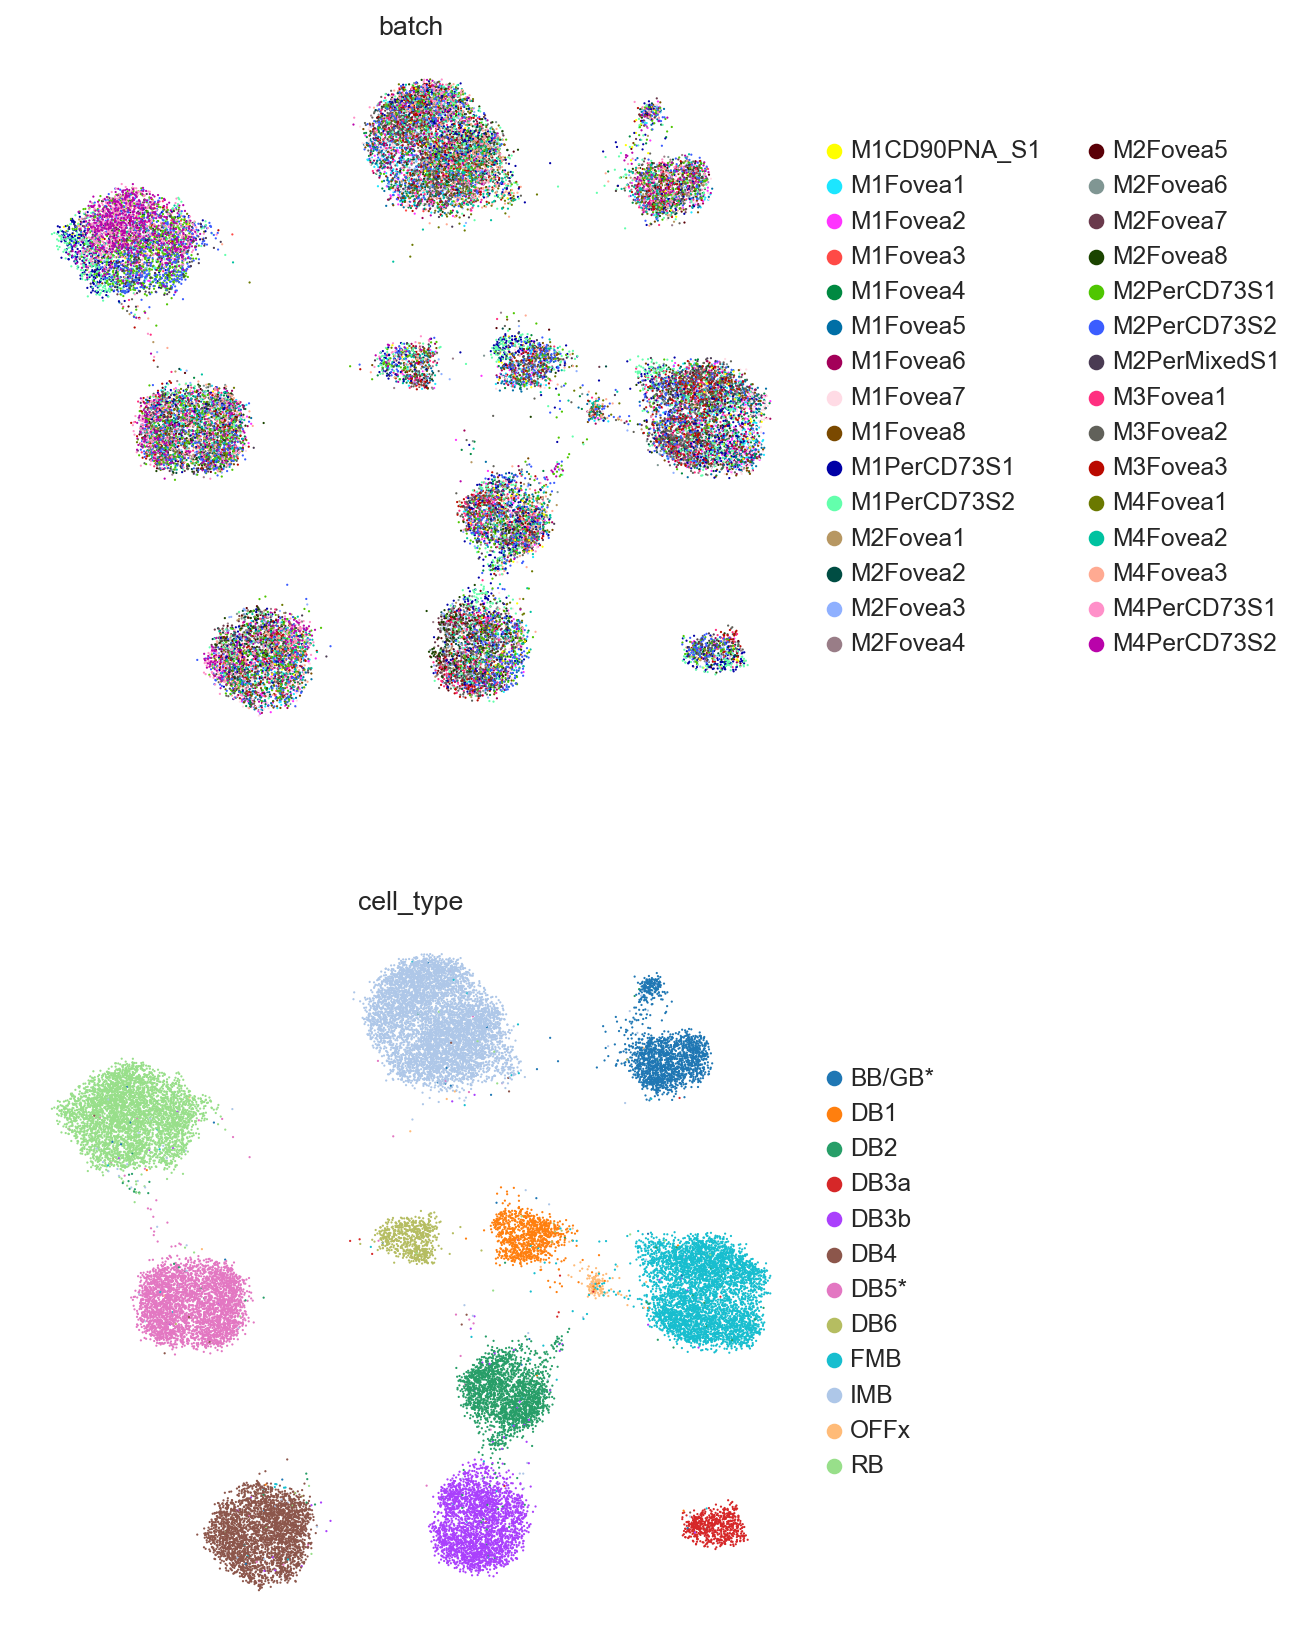

In [42]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [43]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="batch_labels",
    unlabeled_category="Unknown",
)

In [44]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|█| 20/20 [01:56<00:00,  5.70s/it, v_num=1, train_loss_step=431

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [01:56<00:00,  5.83s/it, v_num=1, train_loss_step=431


In [45]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [46]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [47]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

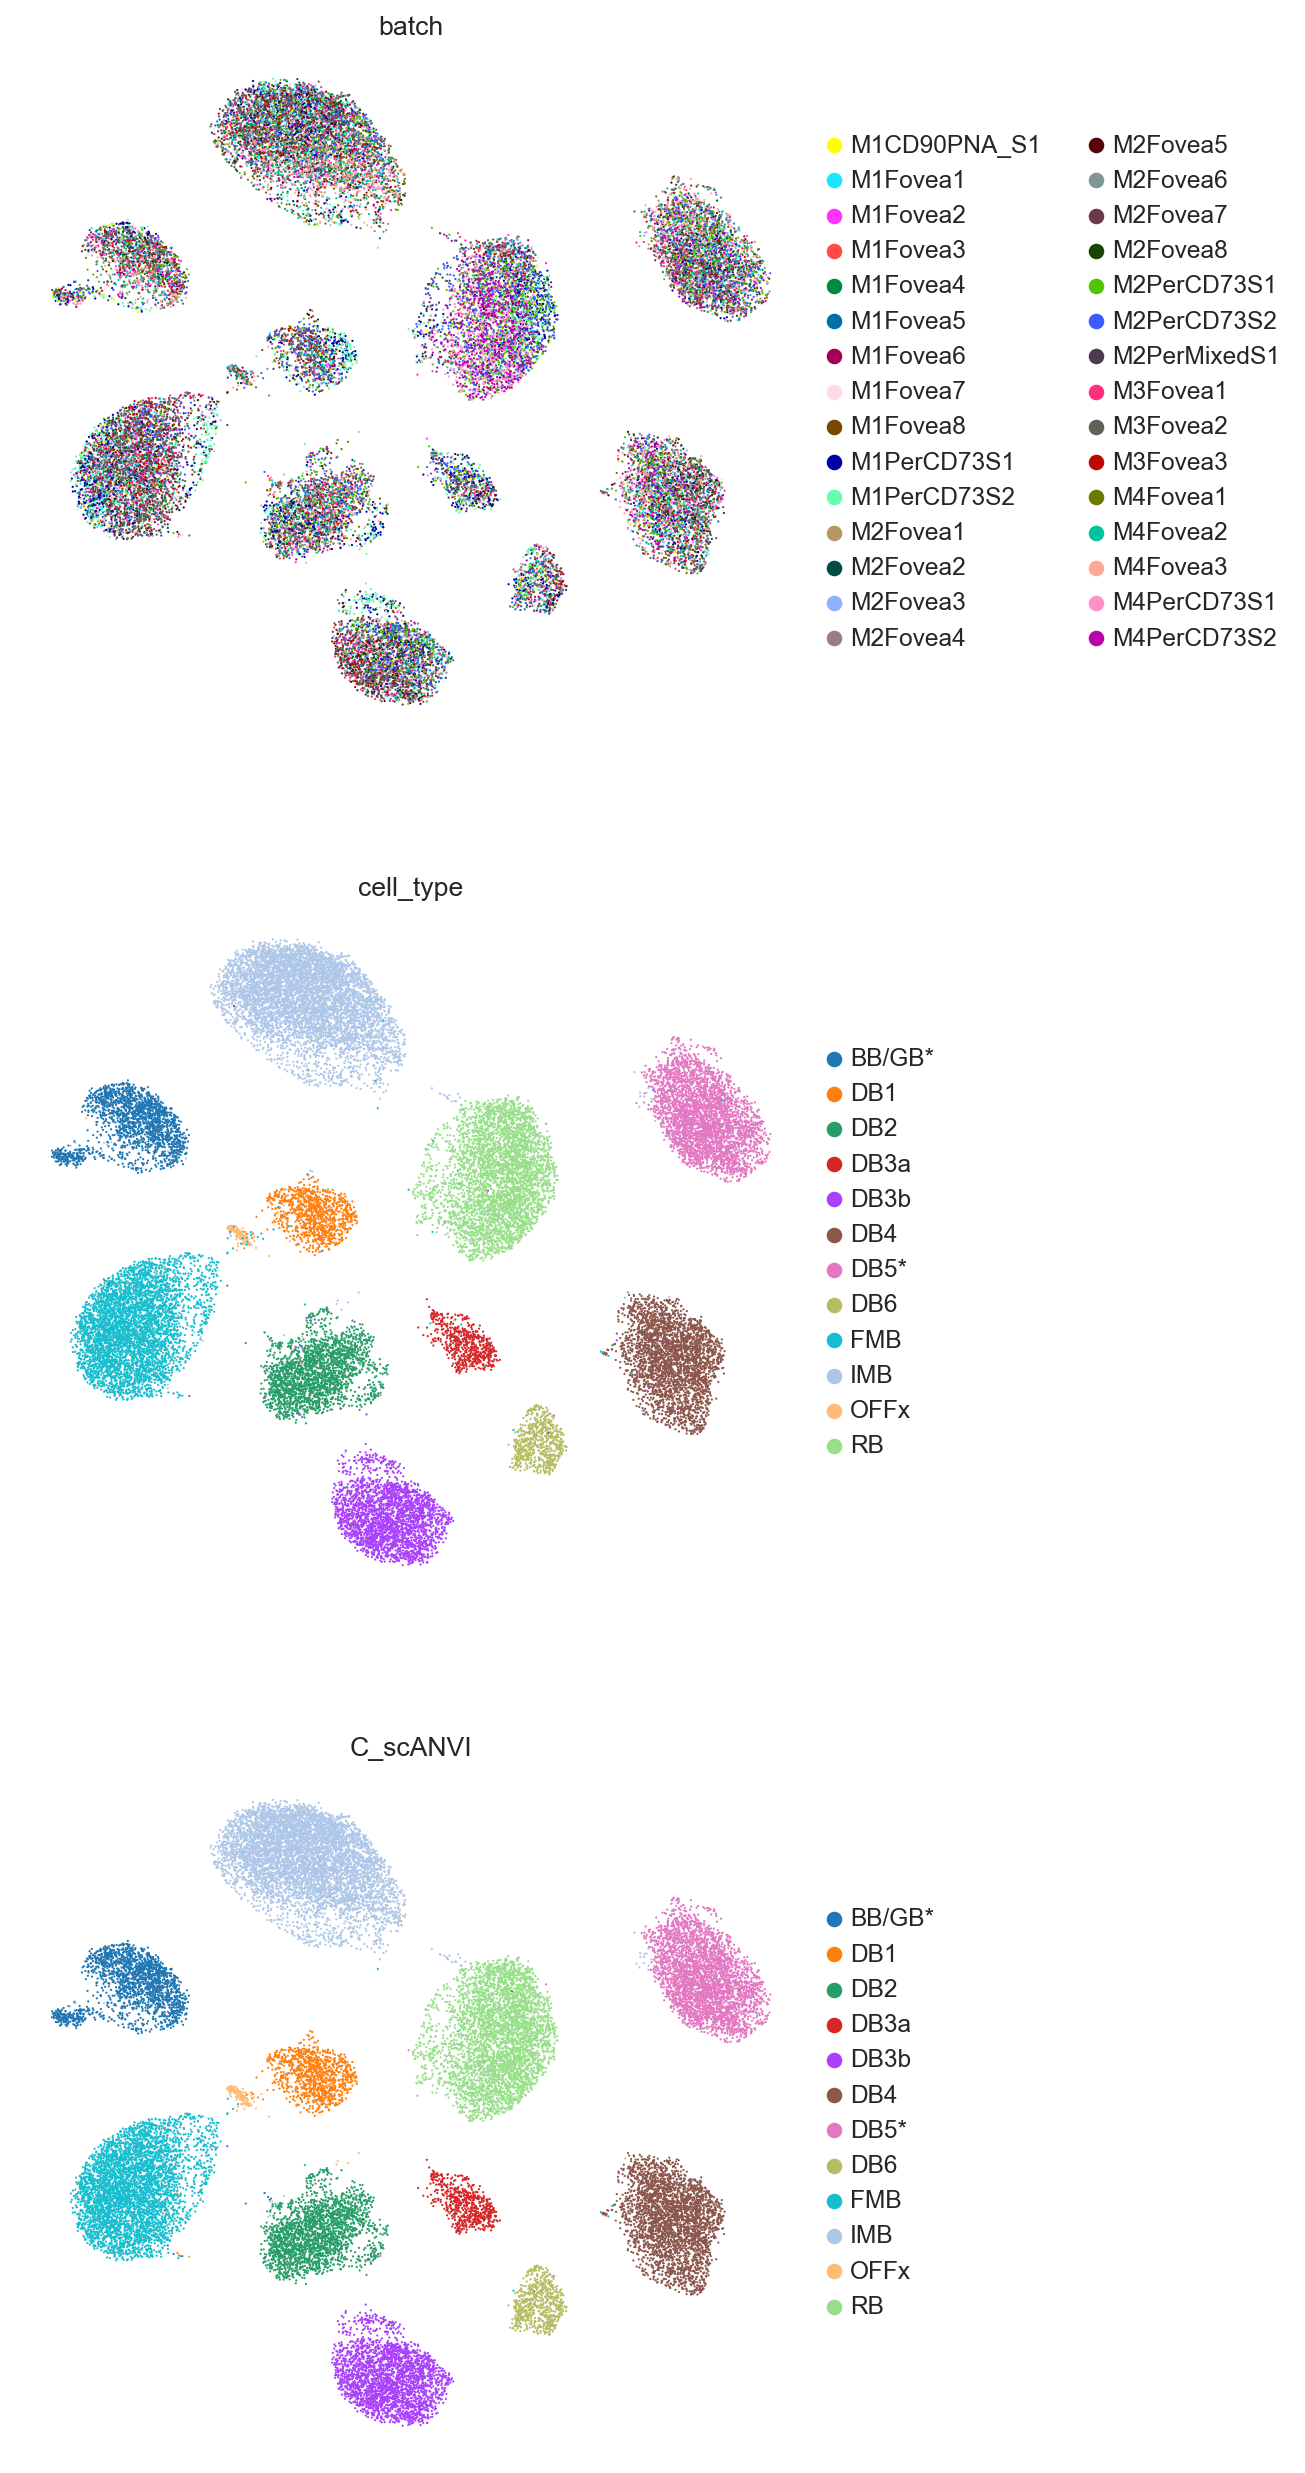

In [48]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [49]:
train = adata.copy()

### Preprocessing Data

In [50]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="batch_labels")

## Creating and Training the model¶

In [51]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|▎| 26/100 [05:18<15:06, 12.25s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1098.917. Signaling Trainer to stop.


## Batch-Removal

In [52]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 30302 × 2000
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH', 'batch_labels', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [53]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [54]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

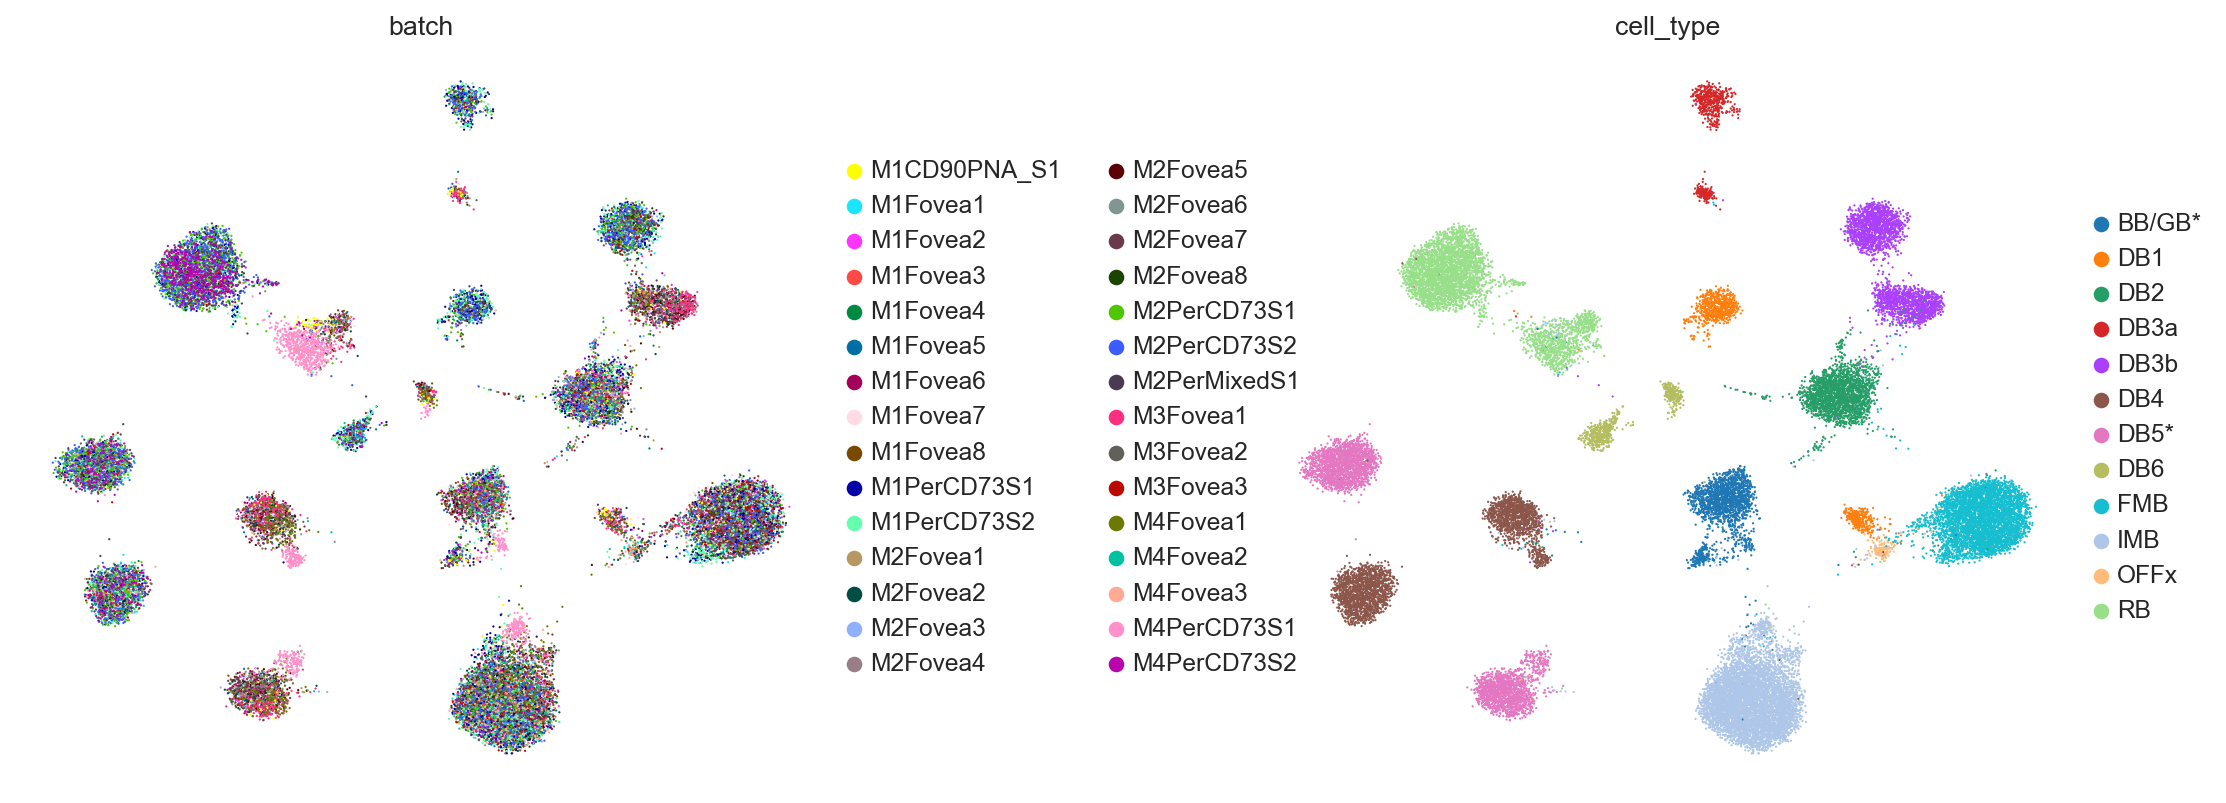

In [55]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [57]:
pca_embeddings = pd.read_csv('../R_macaque/embeddings/macaque_stacas_embeddings_partially_annotated_batches_50.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [58]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

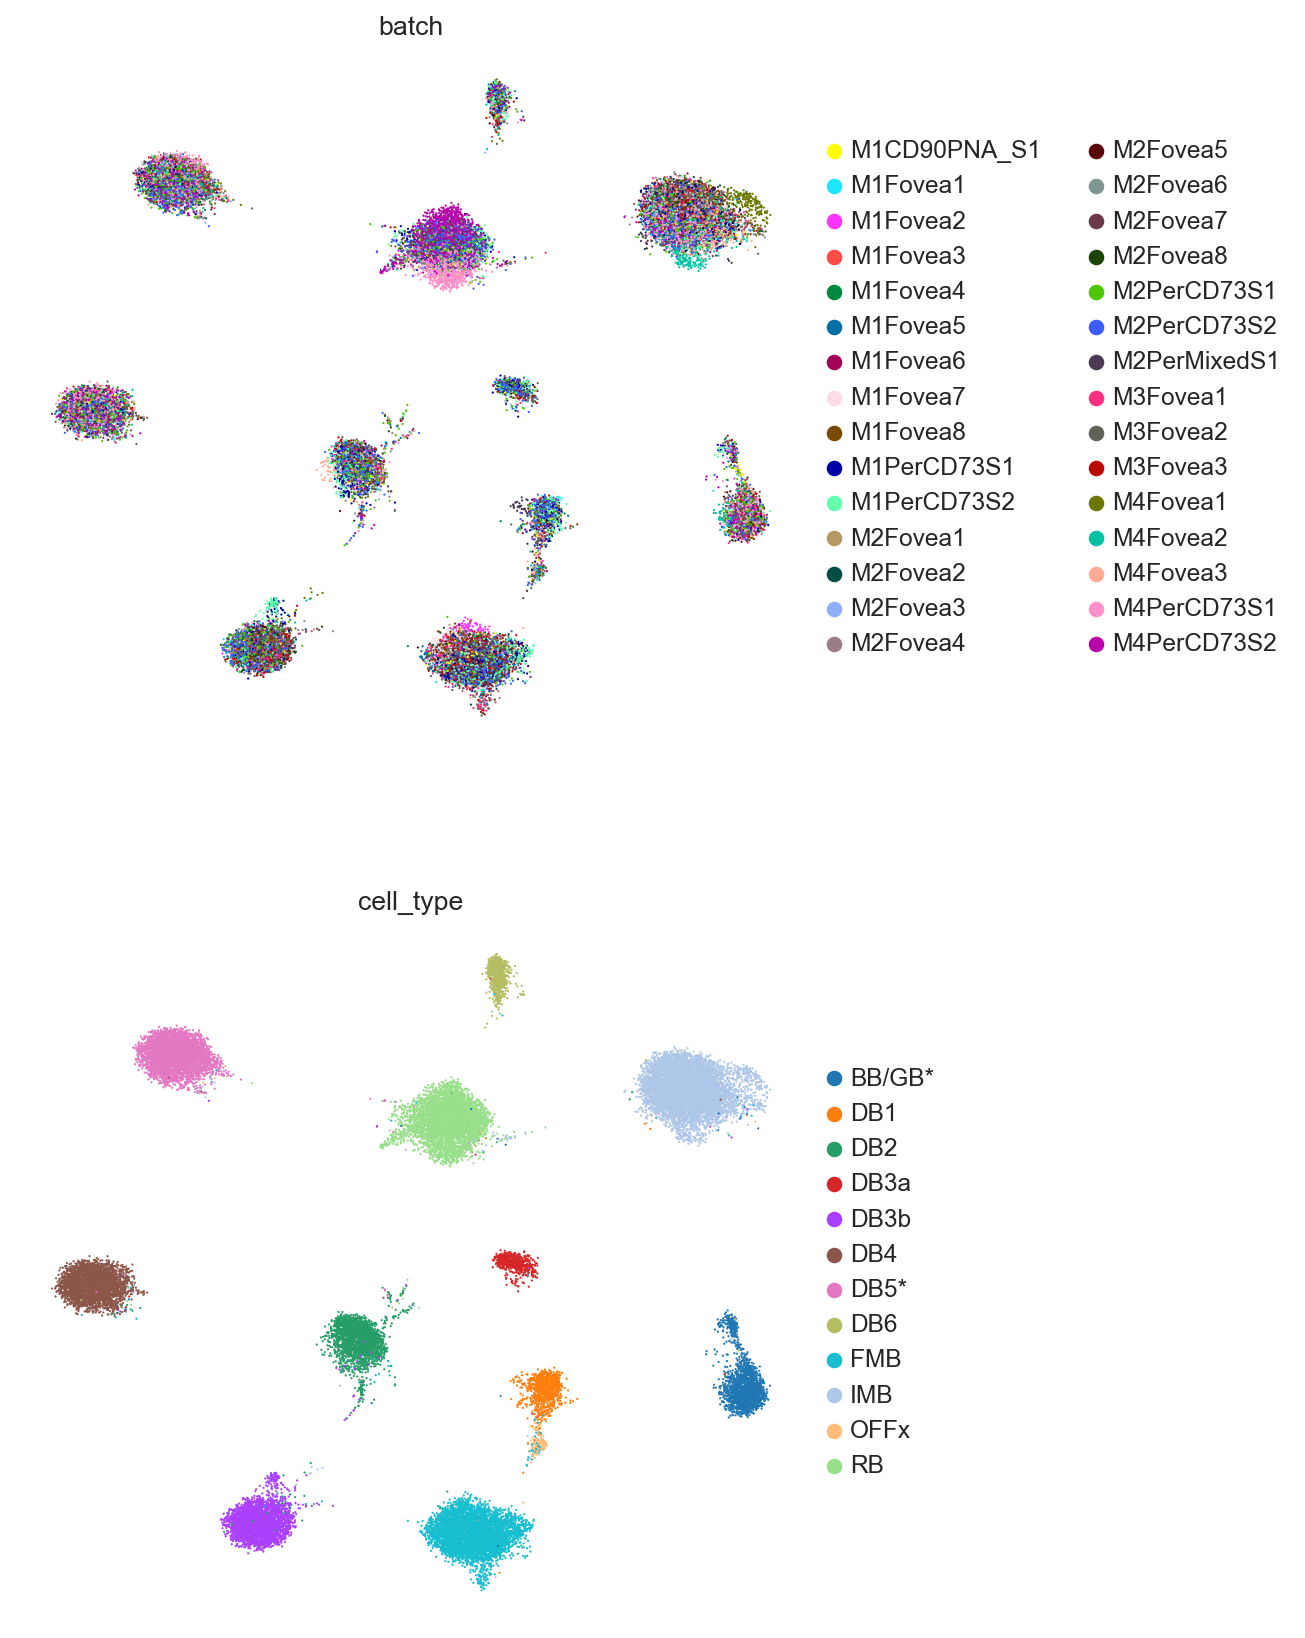

In [59]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [60]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/partially_annotated_batches_macaque_50.csv")


# Metric Evaluation

## read the embeddings

In [ ]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/partially_annotated_batches_macaque_50.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

In [ ]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/macaque_metrics_partially_annotated_batches_50.csv", index=True)

In [ ]:
merged_df